In [1]:
import sympy as sp
import numpy as np
from sympy.physics.vector import dynamicsymbols
from sympy.physics.vector import time_derivative
from sympy.physics.vector import ReferenceFrame
N = ReferenceFrame('N')
import pylab as pl
import control
from EoM import *
from sympy.physics.mechanics import *
from numpy.linalg import matrix_rank, eig
import math
import intelligent_robotics as ir
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import WIP_utils as utils
import modern_robotics as mr
import time as t
import Cal_joint as cj
import traj

In [9]:
time_0, traj_0 = utils.Trapezoidal_Traj_Gen_Given_Amax_and_T(0.4,3.5,0.01)
time_1, traj_1 = utils.Trapezoidal_Traj_Gen_Given_Amax_and_T(1,2,0.01)

horizon_0 = utils.Path_Gen(0, 0.05, traj_0[:,0])
horizon_1 = utils.Path_Gen(0.05, 0.05, traj_1[:,0])
horizon_2 = utils.Path_Gen(0.05, 0, traj_0[:,0])
horizon_3 = utils.Path_Gen(0, 0, traj_1[:,0])
horizon_4 = utils.Path_Gen(0, -0.05, traj_0[:,0])
horizon_5 = utils.Path_Gen(-0.05, -0.05, traj_1[:,0])
horizon_6 = utils.Path_Gen(-0.05, 0, traj_0[:,0])


horizon_0 = np.delete(horizon_0,0)
horizon_1 = np.delete(horizon_1,0)
horizon_2 = np.delete(horizon_2,0)
horizon_3 = np.delete(horizon_3,0)
horizon_4 = np.delete(horizon_4,0)
horizon_5 = np.delete(horizon_5,0)
horizon_6 = np.delete(horizon_6,0)

horizon_1 = np.delete(horizon_1,-1)
# horizon_2 = np.delete(horizon_2,-1)
horizon_3 = np.delete(horizon_3,-1)
# horizon_4 = np.delete(horizon_4,-1)
horizon_5 = np.delete(horizon_5,-1)
# horizon_6 = np.delete(horizon_6,-1)


horizon = np.hstack((horizon_0,horizon_1))
horizon = np.hstack((horizon,horizon_2))
horizon = np.hstack((horizon,horizon_3))
horizon = np.hstack((horizon,horizon_4))
horizon = np.hstack((horizon,horizon_5))
horizon = np.hstack((horizon,horizon_6))

horizon.shape


(2001,)

In [153]:
time, traj = utils.Trapezoidal_Traj_Gen_Given_Amax_and_T(0.0125,20,0.01)
horizon = utils.Path_Gen(0, 0.05, traj[:,2])*190

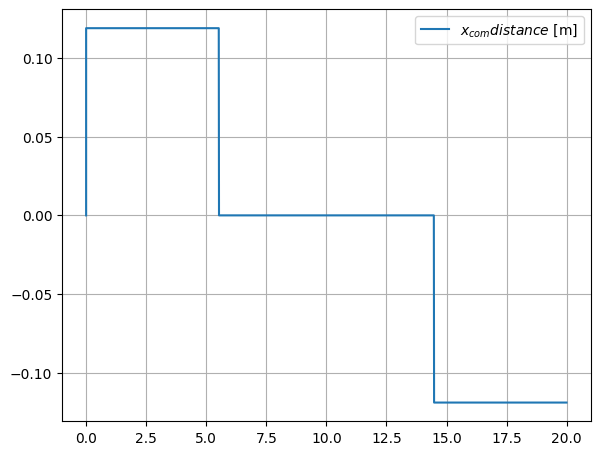

In [154]:

pl.figure(1, figsize=(15,12), dpi=100)
pl.subplot(221);
pl.plot(time, horizon);
pl.legend([r'$x_{com} distance $ [m]'], loc='best')
pl.grid()

plt.show()

In [128]:
thetalistd = cj.get_init_pos(0.9)
thetalistd

array([-0.745238866846359, 1.63070174355873, -0.885462876712376],
      dtype=object)

In [129]:
x,z, x_com, z_com, theta_P = cj.get_end_point(thetalistd[0], thetalistd[1], thetalistd[2])
x,z, x_com, z_com, theta_P

(-0.0268969847812644,
 0.728999999999999,
 -1.15377814977933e-17,
 0.500417013226504,
 -2.3056333403618522e-17)

In [155]:
q2list, q3list, q4list = cj.horizon_angle_traj(0.0125,20,0.01,thetalistd,horizon, z_com)


In [18]:
q2list

array([[-0.745238866846359],
       [-0.745238866846359],
       [-0.746989710242391],
       ...,
       [-0.743485513779895],
       [-0.743485513779895],
       [-0.743485513779895]], dtype=object)

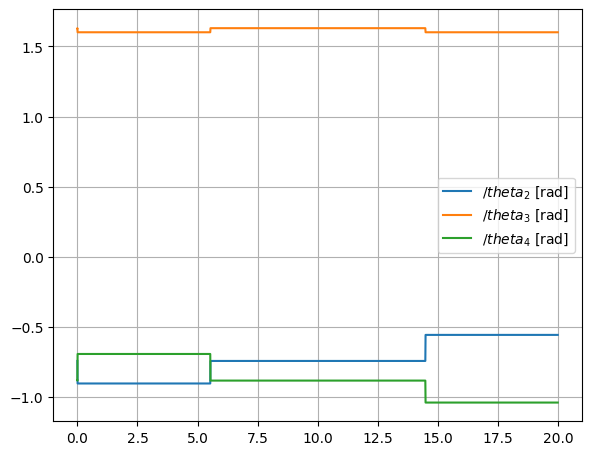

In [131]:
pl.figure(1, figsize=(15,12), dpi=100)
pl.subplot(221);
pl.plot(time, q2list, time, q3list, time, q4list);
pl.legend([r'$/theta_2 $ [rad]', r'$/theta_3 $ [rad]', r'$/theta_4 $ [rad]' ], loc='best')
pl.grid()

plt.show()

0.500417013226504


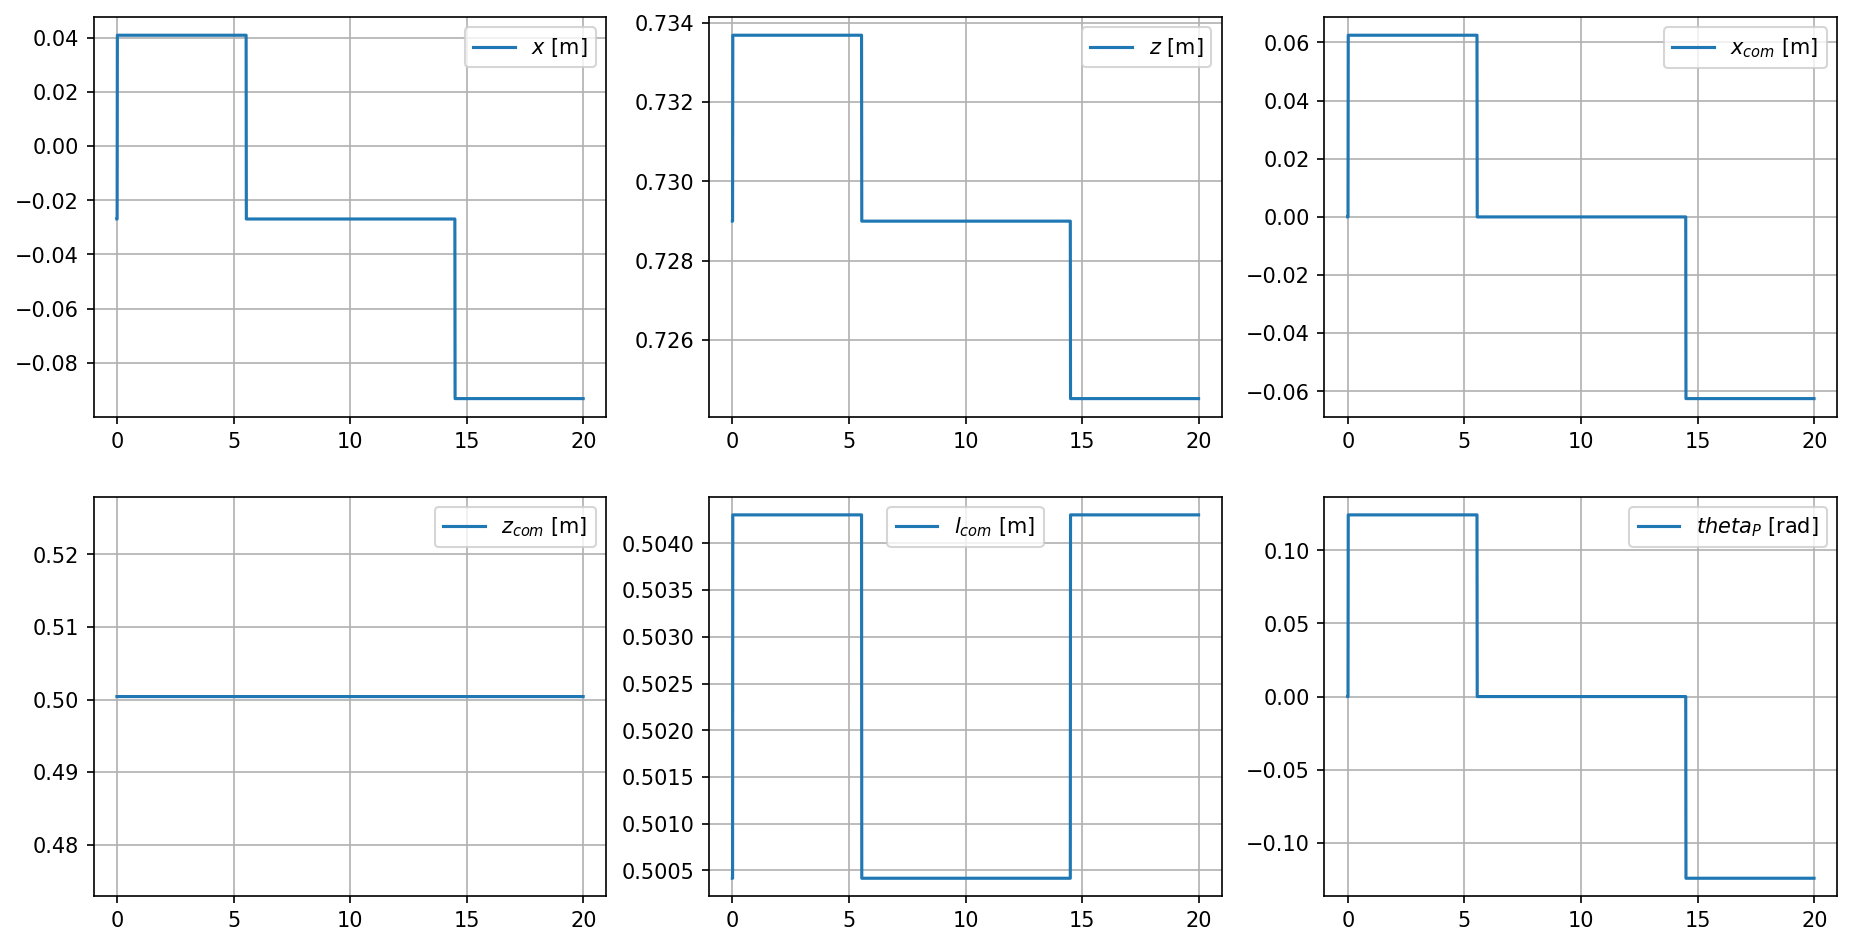

In [132]:

xlist,zlist, x_comlist, z_comlist, l_list, theta_Plist = cj.end_traj(q2list, q3list, q4list)

pl.figure(1, figsize=(15,12), dpi=150)
pl.subplot(331);
pl.plot(time, xlist);
pl.legend([r'$x$ [m]'], loc='best')
pl.grid()

pl.figure(1, figsize=(15,12), dpi=150)
pl.subplot(332);
pl.plot(time, zlist);
pl.legend([r'$z$ [m]'], loc='best')
pl.grid()

pl.figure(1, figsize=(15,12), dpi=150)
pl.subplot(333);
pl.plot(time, x_comlist);
pl.legend([r'$x_{com}$ [m]'], loc='best')
pl.grid()

pl.figure(1, figsize=(15,12), dpi=150)
pl.subplot(334);
pl.plot(time, z_comlist);
pl.legend([r'$z_{com}$ [m]'], loc='best')
pl.grid()

pl.figure(1, figsize=(15,12), dpi=150)
pl.subplot(335);
pl.plot(time, l_list);
pl.legend([r'$l_{com}$ [m]'], loc='best')
pl.grid()

pl.figure(1, figsize=(15,12), dpi=150)
pl.subplot(336);
pl.plot(time, theta_Plist);
pl.legend([r'$theta_P$ [rad]'], loc='best')
pl.grid()


plt.show()

In [133]:
def get_torque_traj(q2list, q3list, q4list):
    time, traj = utils.Trapezoidal_Traj_Gen_Given_Amax_and_T(0.0125,20,0.01)
    # thetalist = get_cur_deg()
    
    m1 = 2.486 + 0.3
    m2 = 1.416
    m3 = 1.739
    m4 = 16.09

    L1 = 0.171
    L2 = 0.28
    L3 = 0.280
    L4 = 0.346

    L1c = L1/2
    L2c = L2 - 0.045289
    L3c = L3 - 0.18878
    L4c = 0.158527

    traj_th2 = q2list
    traj_th3 = q3list
    traj_th4 = q4list

    eint = np.array([ [0.2], [0.2], [0.2]])
    g = np.array([0, 0, -9.8])

    
    M01 = np.array([[1, 0, 0,       0],
                    [0, 1, 0,       0],
                    [0, 0, 1,       0],
                    [0, 0, 0,       1]])
    
    M12 = np.array([[ 1, 0, 0,      0],
                    [ 0, 1, 0,      0],
                    [ 0, 0, 1,       L2c],
                    [ 0, 0, 0,       1]])
    
    M23 = np.array([[1, 0, 0,       0],
                    [0, 1, 0,       0],
                    [0, 0, 1,      (L2-L2c)+L3c],
                    [0, 0, 0,       1]])
    
    M34 = np.array([[1, 0, 0,       0],
                    [0, 1, 0,      0],
                    [0, 0, 1,       (L3-L3c)+L4c],
                    [0, 0, 0,       1]])
    
    G1 = np.diag([0.010192583, 0.009599672, 0.002390603, m2, m2, m2])
    G2 = np.diag([0.008595913, 0.007917693, 0.002944951, m3, m3, m3])
    G3 = np.diag([0.306643651, 0.257336003, 0.140868631, m4, m4, m4]) 
    
    Glist = np.array([G1, G2, G3])
    Mlist = np.array([M01, M12, M23, M34])
    Slist = np.array([[0, -1, 0,      0, 0,     0],
                      [0, 1, 0,   L2,0,     0],
                      [0, -1, 0, -(L2+L3), 0, 0.0]]).T
    Kp = 0.1
    Ki = 0.1
    Kd = 0.1
    dt = 0.01

    torquelist = np.array([[0],[0],[0]])
    dthetalist = np.array([[0], [0], [0]])
    

    for i in range(0, len(time)-1):

        thetalist = np.array([traj_th2[i], traj_th3[i], traj_th4[i]],dtype=float)
        thetalistd = np.array([traj_th2[i+1], traj_th3[i+1], traj_th4[i+1]],dtype=float)
        
        dthetalistd = np.array([ (traj_th2[i+1]-traj_th2[i])/dt, (traj_th3[i+1]-traj_th3[i])/dt, (traj_th4[i+1]-traj_th4[i])/dt],dtype=float)
        ddthetalistd = np.array([(dthetalistd[0]-dthetalist[0])/dt, (dthetalistd[1]-dthetalist[1])/dt, (dthetalistd[2]-dthetalist[2])/dt],dtype=float)

        # torque = mr.ComputedTorque(thetalist, dthetalist, eint, g, Mlist, Glist, Slist,thetalistd, dthetalistd, ddthetalistd, Kp, Ki, Kd)

        # torquelist = np.vstack((torquelist,torque))  
        # dthetalist = dthetalistd

        e = np.subtract(thetalistd, thetalist)
        # print(np.subtract(dthetalistd, dthetalist))

        a = mr.MassMatrix(thetalist, Mlist, Glist, Slist)
        c = Kp * e + Ki * (np.array(eint) + e) \
                + Kd * (np.subtract(dthetalistd, dthetalist))
        # print(a)
        # print( Ki * (np.array(eint) + e))
        
        b = np.array([mr.InverseDynamics(thetalist, dthetalist, ddthetalistd, g, \
                            [0, 0, 0, 0, 0, 0], Mlist, Glist, Slist)]).T
        torque = np.dot(a,c)+b
        # print(a).
        # print(thetalistd)
        # print(thetalist)
        # print(dthetalistd)
        # print(dthetalist)
   
        torquelist = np.vstack((torquelist,torque))  
        dthetalist = dthetalistd
        
        
        # print('------------------------')

        
    return torquelist


In [134]:
torquelist = get_torque_traj( q2list, q3list, q4list)
torque = torquelist.reshape(len(time),3)


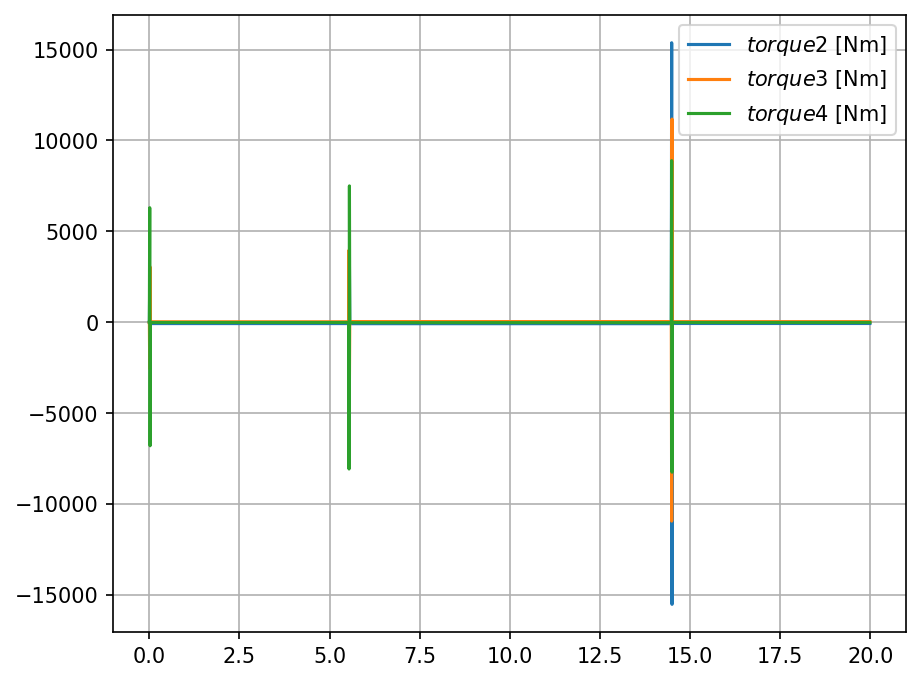

In [135]:

pl.figure(1, figsize=(15,12), dpi=150)
pl.subplot(221);
pl.plot(time,torque);
pl.legend([ r'$torque2$ [Nm]', r'$torque3$ [Nm]', r'$torque4$ [Nm]'], loc='best')
pl.grid()

plt.grid(True, axis='y')

plt.show()

In [136]:
r, L_1 = sp.symbols('r, L_1')
L_1c, L_b = sp.symbols('L_1c, L_b')
m_w, m_1, g, m_b = sp.symbols('m_w, m_1, g, m_b')
I_w, I_1, I_b = sp.symbols('I_w, I_1, I_b')
theta_w, theta_1, theta_2 = dynamicsymbols('theta_w, theta_1, theta_2')

q = sp.Matrix([[theta_w], [theta_1], [theta_2]])
# q = sp.Matrix([[theta_w], [theta_1], [theta_2], [theta_3], [theta_4]])""

qd = q.diff()
qdd = qd.diff()

Ml = sp.Matrix([[1.0*I_w + 1.0*m_1*r**2 + 1.0*m_b*r**2 + 1.0*m_w*r**2, 1.0*r*(L_1*m_b + L_1c*m_1), 2.0*L_b*m_b*r], 
                [1.0*r*(L_1*m_b + L_1c*m_1), 1.0*I_1 + L_1**2*m_b + L_1c**2*m_1, 1.0*L_1*L_b*m_b], 
                [2.0*L_b*m_b*r, 1.0*L_1*L_b*m_b, 1.0*I_b + L_b**2*m_b]])
Cl = sp.Matrix([[0],
                [0],
                [0]])
Gl = sp.Matrix([[0], 
                [-g*(L_1*m_b + L_1c*m_1)*theta_1], 
                [-L_b*g*m_b*theta_2]])
Wl = sp.Matrix([[1, 1],
                [-1, 1],
                [0, 1]])

T_w, T_b= sp.symbols('T_w,T_b')
u = sp.Matrix([[T_w], [T_b]])

In [137]:
# Rough 한 조건식
vmax_ = 0.1
t_ = 14# sec

target_pos = vmax_*t_
v = vmax_/target_pos
a = v/4
v = 0.4

Vmax : 0.3482554348350266 km/r and Amax: 0.001783893985728848 g


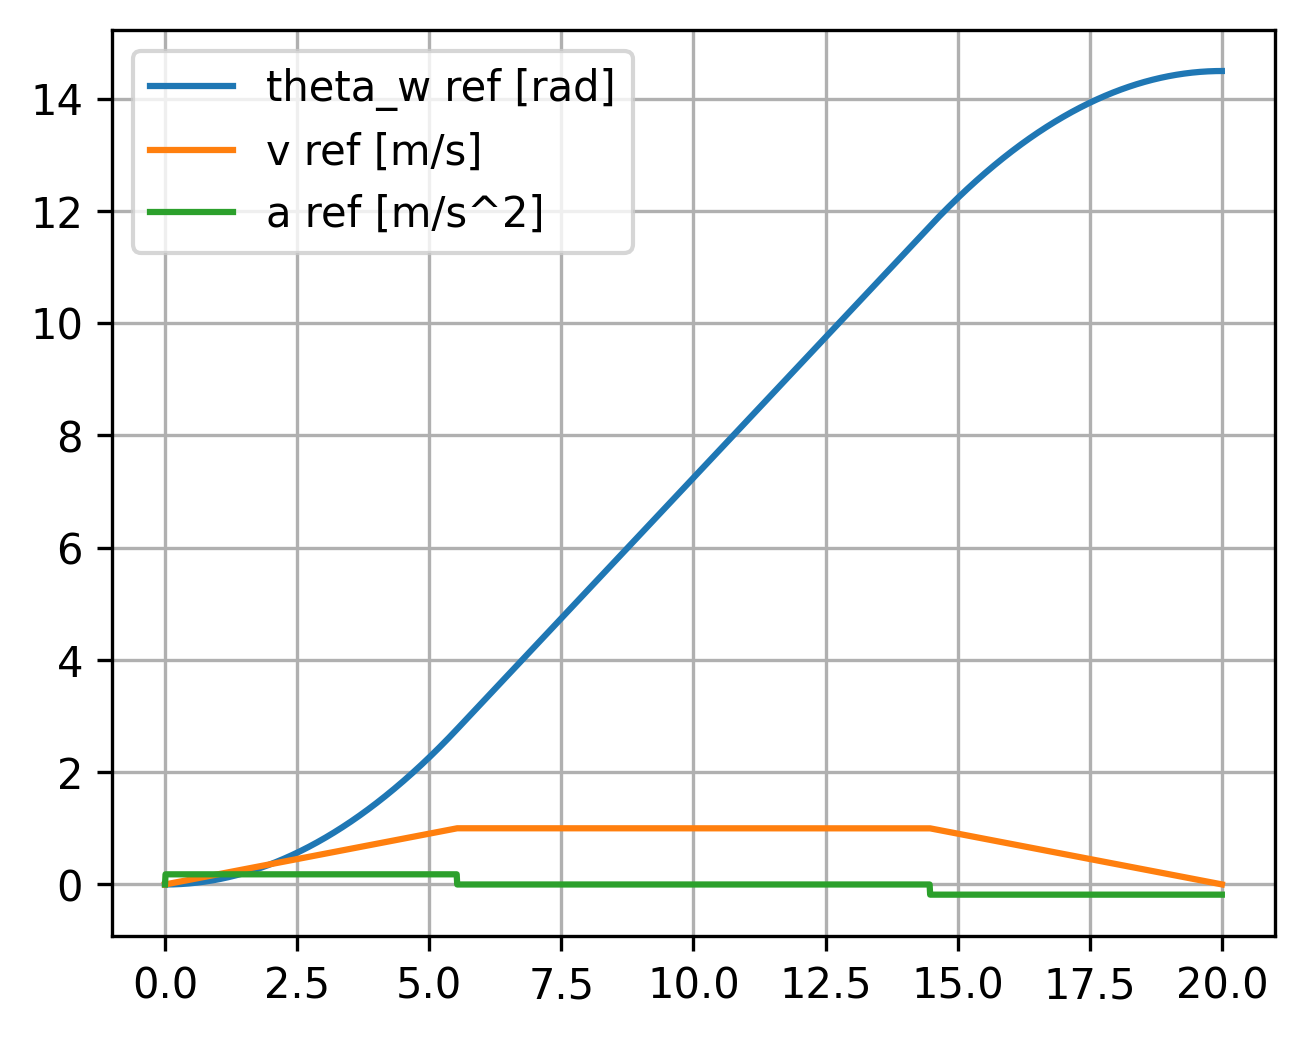

In [138]:
t_s, traj_s = Trapezoidal_Traj_Gen_Given_Amax_and_T(0.0125,20,0.01)


phi_traj = traj_s/ 0.069

pl.figure(1, figsize=(5,4), dpi=300)
pl.plot(t_s, phi_traj)
pl.legend(['theta_w ref [rad]', 'v ref [m/s]', 'a ref [m/s^2]'], loc='best')
pl.grid()

print('Vmax :', max(traj_s[:,1])*target_pos*3.6, 'km/r and Amax:', max(traj_s[:,2])*target_pos/9.81, 'g')

In [139]:
phi_traj[:,1].shape

(2001,)

In [140]:
theta_Plist.T.shape

(1, 2001)

In [141]:
q = sp.Matrix([[theta_w], [theta_1], [theta_2]])

theta_w_des = phi_traj[:,0]*target_pos
theta_wdot_des = phi_traj[:,1]*target_pos
theta_2_des =  theta_Plist.T # using acceleration as xl_des
zeros = np.zeros(len(traj_s))
Xdes = theta_w_des
Xdes = np.vstack((Xdes, zeros))
#Xdes = np.vstack((Xdes, zeros))
Xdes = np.vstack((Xdes, theta_2_des)) 
Xdes = np.vstack((Xdes, theta_wdot_des))
Xdes = np.vstack((Xdes, zeros))
Xdes = np.vstack((Xdes, zeros))
Xdes.shape, Xdes

((6, 2001),
 array([[ 0.00000000e+00,  1.26811594e-05,  5.07246377e-05, ...,
          2.02898043e+01,  2.02898424e+01,  2.02898424e+01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-2.30563334e-17, -2.30563334e-17, -1.15281667e-17, ...,
         -1.24252429e-01, -1.24252429e-01, -1.24252429e-01],
        [ 0.00000000e+00,  2.53623188e-03,  5.07246377e-03, ...,
          5.07246377e-03,  2.53623188e-03,  2.53623188e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]))

In [142]:
def get_K_list(l_list):
    
    K_list = []
    A_list = []
    B_list = []
    
    for i in range(0, len(l_list)-1):
        param = {L_b: float(l_list[i]),m_b: 19.245,T_b :10,I_1: 0.007514491, I_w:0.004806909,I_b :0.572443057472749,  m_1:2.786,   m_w:2.292, r:0.069,L_1c:0.15, L_1: 0.171,  g:9.81}

        Mlp = msubs(Ml, param)
        Clp = msubs(Cl, param)
        Glp = msubs(Gl, param)
        Wlp = msubs(Wl, param)

        Mlp_inv = Mlp.inv()
        qdd_rhs_A = Mlp_inv*(-Clp -Glp)
        qdd_rhs_B = Mlp_inv*Wlp*u

        X = q.col_join(qd)
        Xd_A = qd.col_join(qdd_rhs_A)
        Xd_B = qd.col_join(qdd_rhs_B)
        U = u

        A = Xd_A.jacobian(X)
        B = Xd_B.jacobian(U)
        C = X.jacobian(X)
        D = X.jacobian(U)
        
        # print(A)
        
        # ss0 = [A, B, C, D]
        # sys0 = control.ss(*[pl.array(mat_i.subs(param)).astype(float) for mat_i in ss0])
        
        Q = sp.Matrix([ [1,0,0,0,0,0],
                [0,1,0,0,0,0],
                [0,0,1,0,0,0],
                [0,0,0,1,0,0],
                [0,0,0,0,1,0],
                [0,0,0,0,0,1] ])
        R = sp.Matrix([ [10,0],
                        [0,10] ])

        K, S, E = control.lqr(A, B, Q, R)
        
        K_list.append(K)
        A_list.append(A)
        B_list.append(B)
    return K_list, A_list, B_list

K_list, A_list, B_list = get_K_list(l_list)
K_list = np.array(K_list)
A_list = np.array(A_list)
B_list = np.array(B_list)

In [97]:
K_list = K_list.reshape(2001,2,6)

In [99]:
A_list = A_list.reshape(2001,6,6) 

In [103]:
B_list = B_list.reshape(2001,6,2) 

In [143]:
K_list.shape

(2000, 2, 6)

In [123]:
K_list

array([[[-1.47532700e-02, -4.64843315e+01,  1.34602622e+01,
         -6.97060623e-02, -4.00866475e+00, -9.63428745e-01],
        [ 3.15883429e-01,  1.50091292e+01,  1.02940237e+01,
          5.38333436e-01,  2.25247480e+00,  6.11459647e+00]],

       [[-1.47532700e-02, -4.64843315e+01,  1.34602622e+01,
         -6.97060623e-02, -4.00866475e+00, -9.63428745e-01],
        [ 3.15883429e-01,  1.50091292e+01,  1.02940237e+01,
          5.38333436e-01,  2.25247480e+00,  6.11459647e+00]],

       [[-1.47532700e-02, -4.64843315e+01,  1.34602622e+01,
         -6.97060623e-02, -4.00866475e+00, -9.63428745e-01],
        [ 3.15883429e-01,  1.50091292e+01,  1.02940237e+01,
          5.38333436e-01,  2.25247480e+00,  6.11459647e+00]],

       ...,

       [[-1.47532941e-02, -4.64843285e+01,  1.34602574e+01,
         -6.97061077e-02, -4.00866447e+00, -9.63430542e-01],
        [ 3.15883428e-01,  1.50091271e+01,  1.02940322e+01,
          5.38333495e-01,  2.25247464e+00,  6.11460102e+00]],

       [[-1

In [122]:
K_list[0][1][0:]

array([ 0.31588343, 15.00912916, 10.29402374,  0.53833344,  2.2524748 ,
        6.11459647])

In [117]:
K_list[0][0][0:]

array([-1.47532700e-02, -4.64843315e+01,  1.34602622e+01, -6.97060623e-02,
       -4.00866475e+00, -9.63428745e-01])

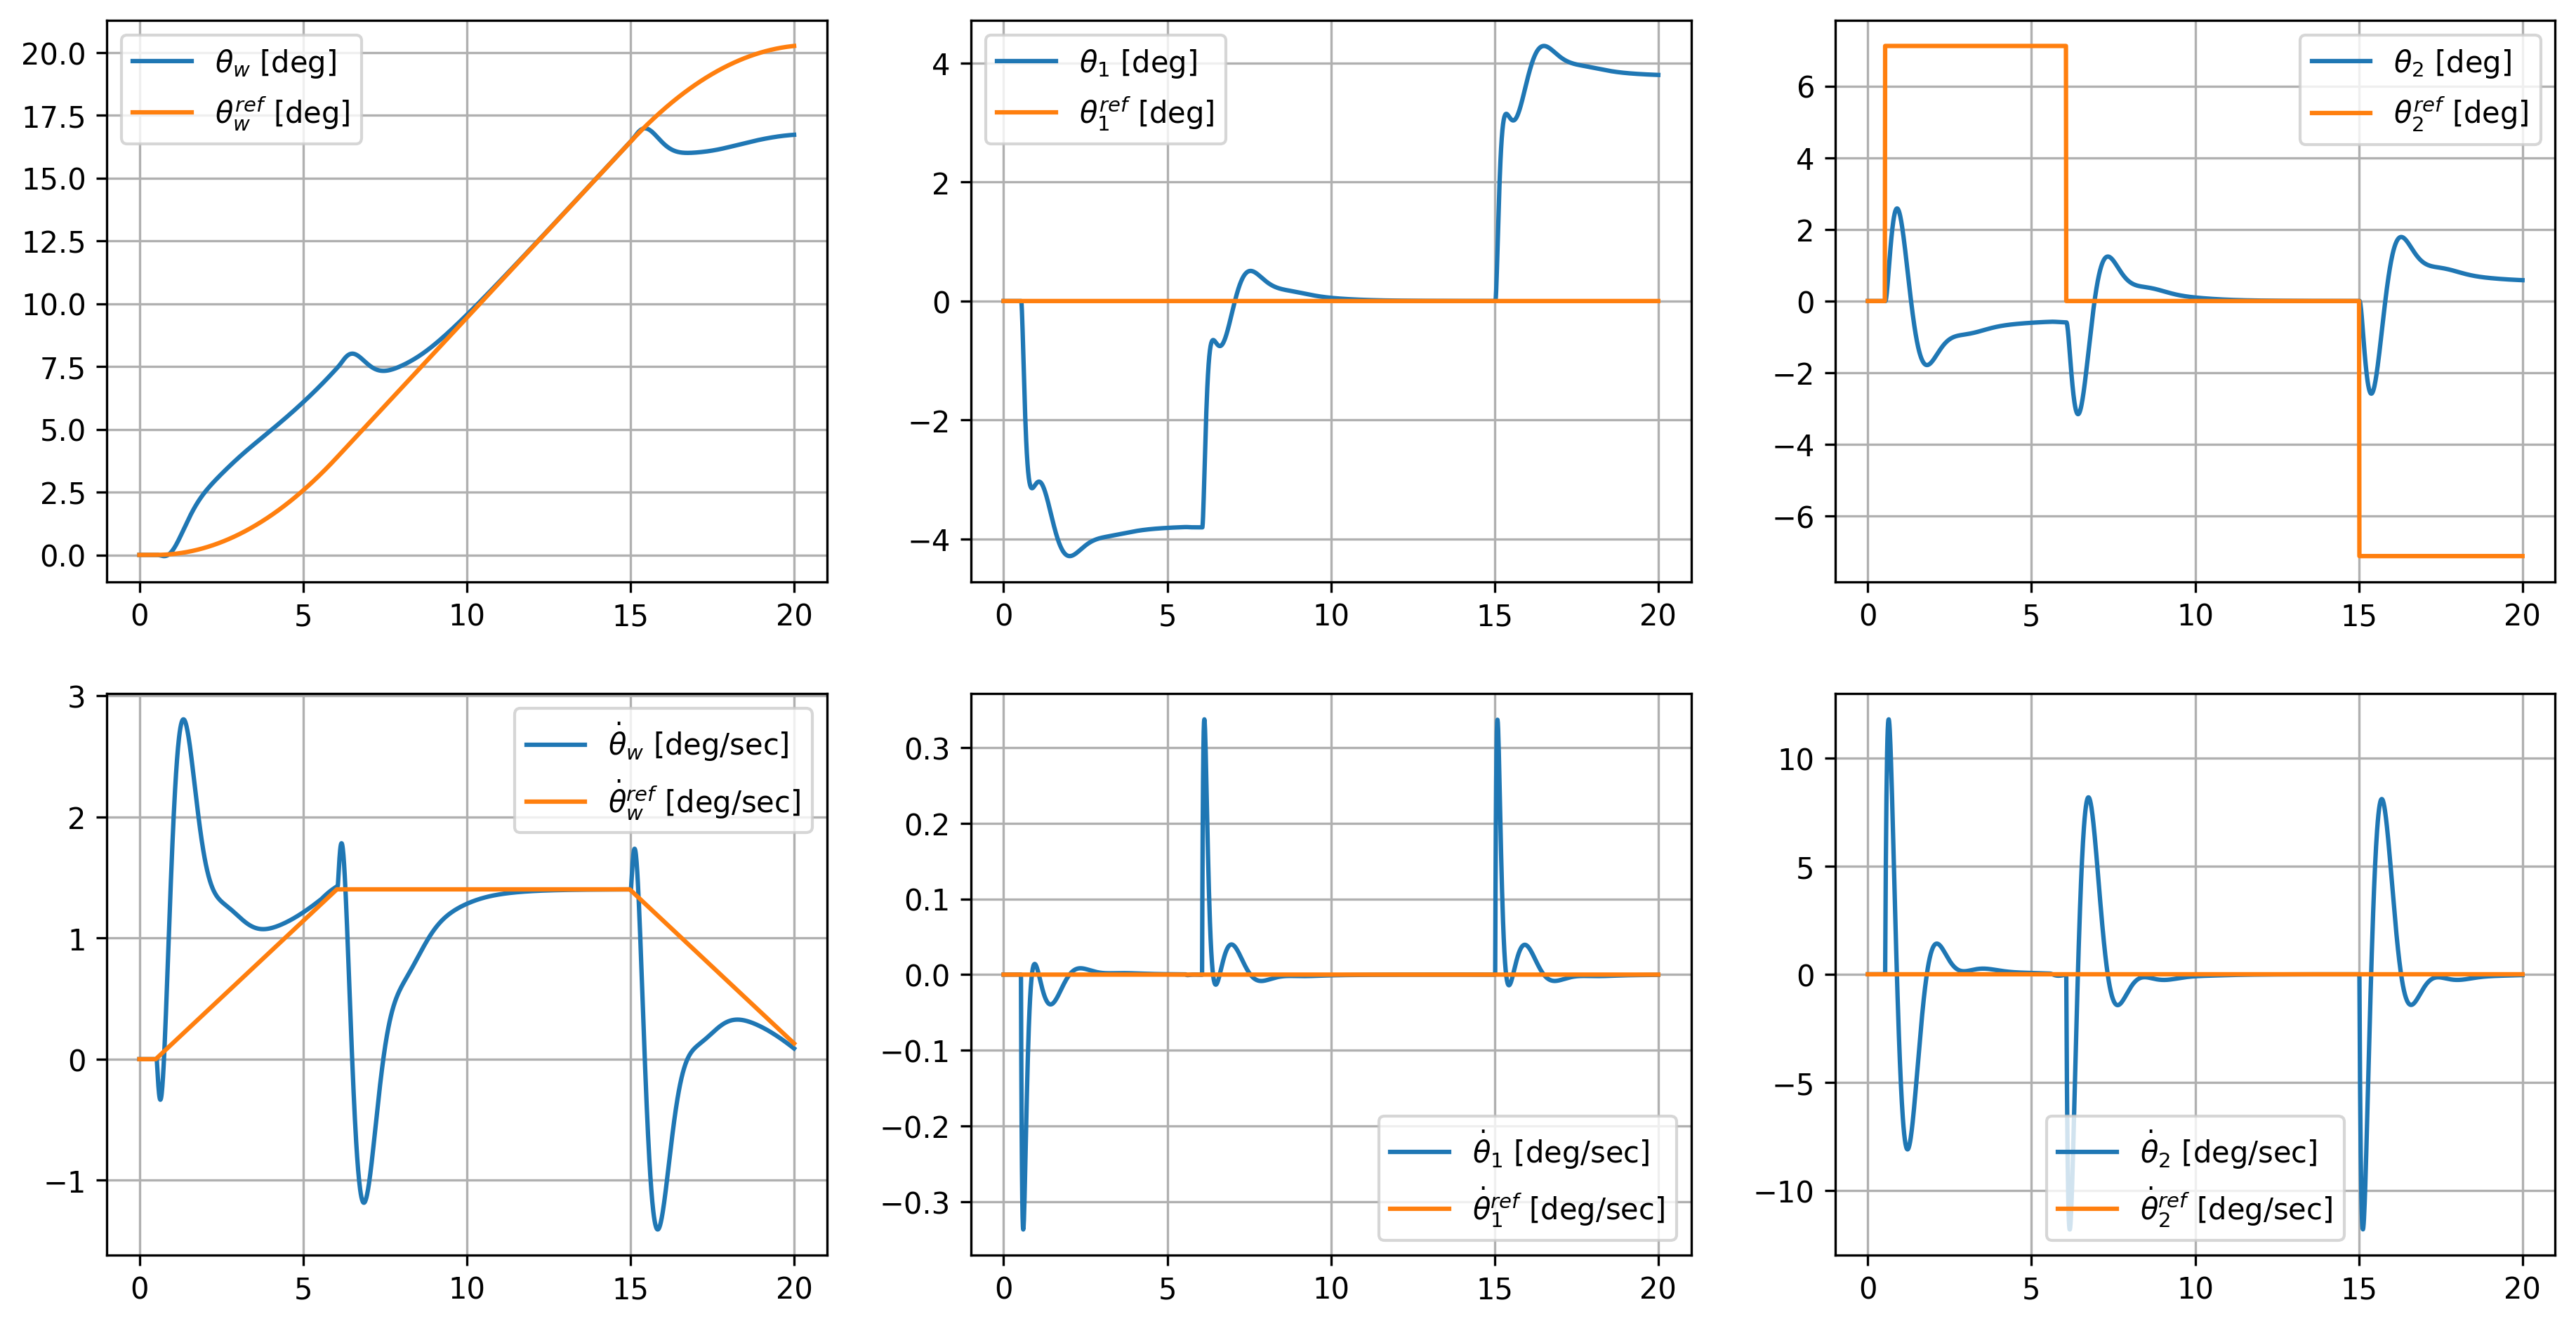

In [145]:
# Closed-loop Simulation

rad2deg = 180/np.pi

def simulate_model_closed(Alist, Blist, X0, Xdes, K_gain, time_array, dt):

        
    t = 0
    j = 0
    X = Xref = Xd_prev = Xd = X0
    
    t_save = [0]
    x_save = xref_save = np.array([0,0,0,0,0,0])
    u_save = np.array([0,0])
    
    for i in range(len(time_array)):
        t = time_array[i]
         
        if t<0.5:
            Xref = X0       
        elif t>=0.5 and j<(Xdes.shape[1]):
            Xref = Xdes[:,j]
            j+=1
        else:
            Xdes_final = Xdes[:,Xdes.shape[1]-1]
            Xdes_final[2] = 0 # force to set xl_des as 0
            Xref = Xdes_final

        # full-state feedback
        #u = K@(Xgoal - X)

        # partial feedback
        u1 = K_gain[i][0][0:]@(Xref[0:] - X[0:])
        u2 = K_gain[i][1][0:]@(Xref[0:] - X[0:])
        
        # Forward Dynamics
        Xd_prev = Xd
        # Linear Model
        u = [u1, u2]
        # print(u)
        Xd = Alist[i]@X + Blist[i]@u # Xd = [xd, x_ld, thetad, xdd, x_ldd, thetadd]
        # NonLinear Model
        #q_qd = {x:X[0], x_l:X[1], theta:X[2], x.diff():X[3], x_l.diff():X[4], theta.diff():X[5]}
        #q_qd[F] = u1
        #q_qd[F_l] = u2
        #qdd = msubs(qdd_rhs_A_nonL,q_qd) + msubs(qdd_rhs_B_nonL,q_qd)
        #Xd = np.array([X[3], X[4], X[5], float(qdd[0]), float(qdd[1]), float(qdd[2])])
        
        t_save = np.vstack((t_save, t))
        x_save = np.vstack((x_save, X))
        # print(xref_save)
        # print(Xref)
        xref_save = np.vstack((xref_save, Xref))
        u_save = np.vstack((u_save, np.array([u1,u2])))
        
        X = X + Xd*dt
        t = t + dt
        i+=1
        
        # #limit setting
        # xl_limit = 0.5
        # if X[1] >= xl_limit:
        #     X[1] = xl_limit
        # elif X[1] <= -xl_limit:
        #     X[1] = -xl_limit
                 
    return t_save, x_save, xref_save, u_save

# initial condition
# [x, x_l, theta, x_dot,x_l_dot, theta_dot]
X0 = np.array([0,0,0,0,0,0])

tf = 20
dt = 0.01
N = int(tf/dt)

# time points
t = np.linspace(0,tf,N)

# simulation
t_sim, x_sim, xref_sim, u_sim = simulate_model_closed(A_list, B_list, X0, Xdes, K_list, t, dt)

pl.figure(1, figsize=(15,12), dpi=300)
pl.subplot(331);
pl.plot(t_sim, x_sim[:,0], t_sim, xref_sim[:,0]);
pl.legend([r'$\theta_w$ [deg]', r'$\theta_w^{ref}$ [deg]'], loc='best')
pl.grid()

pl.subplot(332);
pl.plot(t_sim, x_sim[:,1]*rad2deg, t_sim, xref_sim[:,1]*rad2deg);
pl.legend([r'$\theta_1$ [deg]', r'$\theta_1^{ref}$ [deg]'], loc='best')
pl.grid()

pl.subplot(333);
pl.plot(t_sim, x_sim[:,2]*rad2deg, t_sim, xref_sim[:,2]*rad2deg);
pl.legend([r'$\theta_2$ [deg]', r'$\theta_2^{ref}$ [deg]'], loc='best')
pl.grid()

pl.subplot(334);
pl.plot(t_sim, x_sim[:,3], t_sim, xref_sim[:,3]);
pl.legend([r'$\dot\theta_w$ [deg/sec]', r'$\dot\theta_w^{ref}$ [deg/sec]'], loc='best')
pl.grid()

pl.subplot(335);
pl.plot(t_sim, x_sim[:,4], t_sim, xref_sim[:,4]);
pl.legend([r'$\dot\theta_1$ [deg/sec]', r'$\dot\theta_1^{ref}$ [deg/sec]'], loc='best')
pl.grid()

pl.subplot(336);
pl.plot(t_sim, x_sim[:,5]*rad2deg, t_sim, xref_sim[:,5]*rad2deg);
pl.legend([r'$\dot\theta_2$ [deg/sec]', r'$\dot\theta_2^{ref}$ [deg/sec]'], loc='best')
pl.grid()

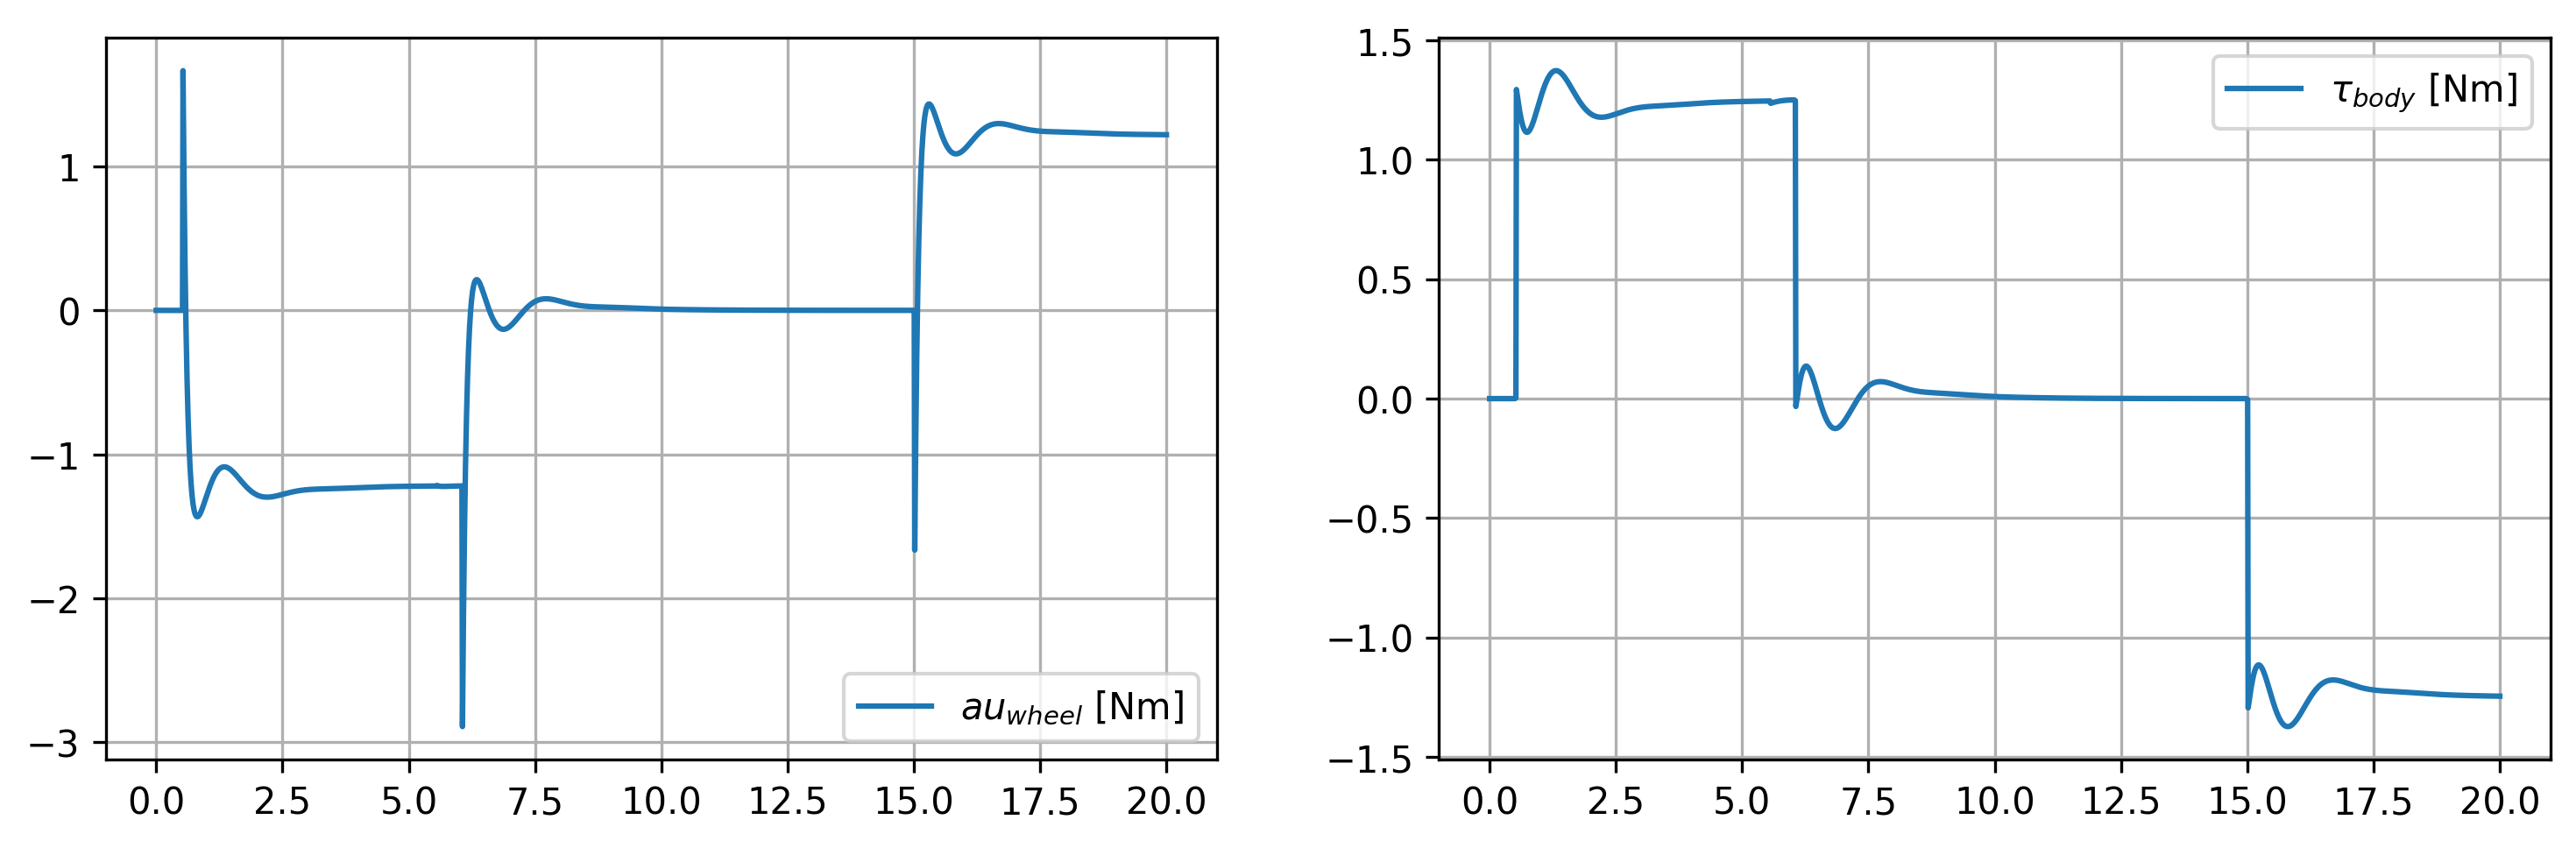

In [146]:
pl.figure(2, figsize=(12,8), dpi=300)
pl.subplot(221);
pl.plot(t_sim, u_sim[:,0]);
pl.legend(['$\tau_{wheel}$ [Nm]'], loc='best')
pl.grid()

pl.subplot(222);
pl.plot(t_sim, u_sim[:,1]);
pl.legend([r'$\tau_{body}$ [Nm]'], loc='best')
pl.grid()